# Gumbel Softmax
## How to use GAN for sequences?

In a gan notebook we explored how GAN's can be used to approximate some continuous distribution. At it's core there were a generator function $G$ (neural network) which took a random gaussian noise as an input and produced a vector of numbers (possibly of size one, as in our simple one-dimensional example) that resembled the ones coming from real data distribution. We can easily see how this can be applied to generate random images - we just let the network output the vector with the size of the image and train adversarially against a discriminator like usual.

But what if we were intrested in taking this approach to generate text? Well, let's think for a moment. To generate this sequences we would need a generator. It can also take some random noise, and produce a sequence of numbers. We can take some ideas here from machine translation. The random noise could be the input to the recurrent neural network as a first hidden state - it would capture (possibly after some transformation with a feed-forward neural network) the meaning that we would like to encode in a sentence. In that way it could produce a bunch of output words until the stop token being generated. We would have to think about a solution to stop this solution from being too long at the beginning of training, but in general this seems like a plausible approach.

What about the discriminator? It takes as an input what generator produces as an output. In this case it is a sequence of words, so the natural candidate for a discriminator is a recurrent neural network as well. The discriminator would then produce a number from 0 to 1, with 0 being certain that this is a good sample and 1 if certain that this is fake. We can also observe that for samples coming form real world distribution (real sentences) discriminator is simply a language model - it gives each sentence a probability.  So this is it, right?

Wrong. What we didn't take into account how we are going to train this network. Well, this is obvious - with gradient descent. But let's keep in mind, that the loss for training generator is a value of discriminator (or it's function like logarithm, which doesn't change the point we are making): $L(\theta_G) = D(G(z; \theta_G))$. So in order to calculate the derivative we have to calculate $\frac{\partial}{\partial \theta_G} D(G(z; \theta_G)) = \frac{\partial}{\partial G}D(G) \frac{\partial}{\partial \theta_G} G$. It seems a little bit weird since $G$ is now a sequence of discrete elements from a vocabulary, what would it mean to differentiate by it? In the case of continuous values of discriminator it wasn't a problem, we could diffentiate by a value of an input just as we would differentiate with respect to weights. Here it is completely differrent - we cannot differentiate a function with a discrete input. That's like differentiating a sequence with respect to some natural number, doesn't make sense by definition.

## Gumbel Softmax
First, we will try to understand how Gumbel-Softmax works.

https://anotherdatum.com/gumbel-gan.html

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline

In [2]:
BATCHS_IN_EPOCH = 100
BATCH_SIZE = 10
EPOCHS = 200  # the stream is infinite so one epoch will be defined as BATCHS_IN_EPOCH * BATCH_SIZE
GENERATOR_TRAINING_FACTOR = 10  # for every training of the disctiminator we'll train the generator 10 times
LEARNING_RATE = 0.0007
TEMPERATURE = 0.001  # we use a constant, but for harder problems we should anneal it

In [3]:
# Creating Dataset

number_to_prob = {
    0: 0.0,
    1: 0.2,
    2: 0.1,
    3: 0.1,
    4: 0.6
}


def generate_text():
    while True:
        yield np.random.choice(list(number_to_prob.keys()), p=list(number_to_prob.values()), size=1)

        
dataset = tf.data.Dataset.from_generator(generate_text,
                                         output_types=tf.int32,
                                         output_shapes=1).batch(BATCH_SIZE)
value = dataset.make_one_shot_iterator().get_next()
value = tf.one_hot(value, len(number_to_prob))
value = tf.squeeze(value, axis=1)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [4]:
def generator():
    with tf.variable_scope('generator'):
        logits = tf.get_variable('logits', initializer=tf.ones([len(number_to_prob)]))
        gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(TEMPERATURE, logits=logits)
        probs = tf.nn.softmax(logits)
        generated = gumbel_dist.sample(BATCH_SIZE)
        return generated, probs

In [5]:
def discriminator(x):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        return tf.contrib.layers.fully_connected(x,
                                                 num_outputs=1,
                                                 activation_fn=None)

In [6]:
generated_outputs, generated_probs = generator()
discriminated_real = discriminator(value)
discriminated_generated = discriminator(generated_outputs)

d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminated_real,
                                            labels=tf.ones_like(discriminated_real)))
d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminated_generated,
                                            labels=tf.zeros_like(discriminated_generated)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminated_generated,
                                            labels=tf.ones_like(discriminated_generated)))

all_vars = tf.trainable_variables()
g_vars = [var for var in all_vars if var.name.startswith('generator')]
d_vars = [var for var in all_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(LEARNING_RATE).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(LEARNING_RATE).minimize(g_loss, var_list=g_vars)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    learned_probs = []
    for _ in tqdm(range(EPOCHS)):
        for _ in range(BATCHS_IN_EPOCH):
            sess.run(d_train_opt)
            for _ in range(GENERATOR_TRAINING_FACTOR):
                sess.run(g_train_opt)
        learned_probs.append(sess.run(generated_probs))

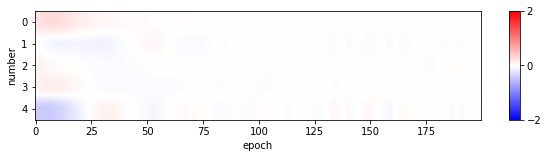

In [21]:
plt.figure(figsize=(10, 2))
prob_errors = [np.array(learned_prob) - np.array(list(number_to_prob.values()))
               for learned_prob in learned_probs]
plt.imshow(np.transpose(prob_errors),
           cmap='bwr',
           aspect='auto',
           vmin=-2,
           vmax=2)
plt.xlabel('epoch')
plt.ylabel('number')
plt.colorbar(aspect=10, ticks=[-2, 0, 2]);